In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
prices = pd.read_csv('prices.txt', delim_whitespace=True, header=None)
plt.figure(figsize=(15, 8))
corr = prices.corr()

C:\Users\Ben\AppData\Local\Temp\ipykernel_21408\1507237307.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  prices = pd.read_csv('prices.txt', delim_whitespace=True, header=None)


<Figure size 1500x800 with 0 Axes>

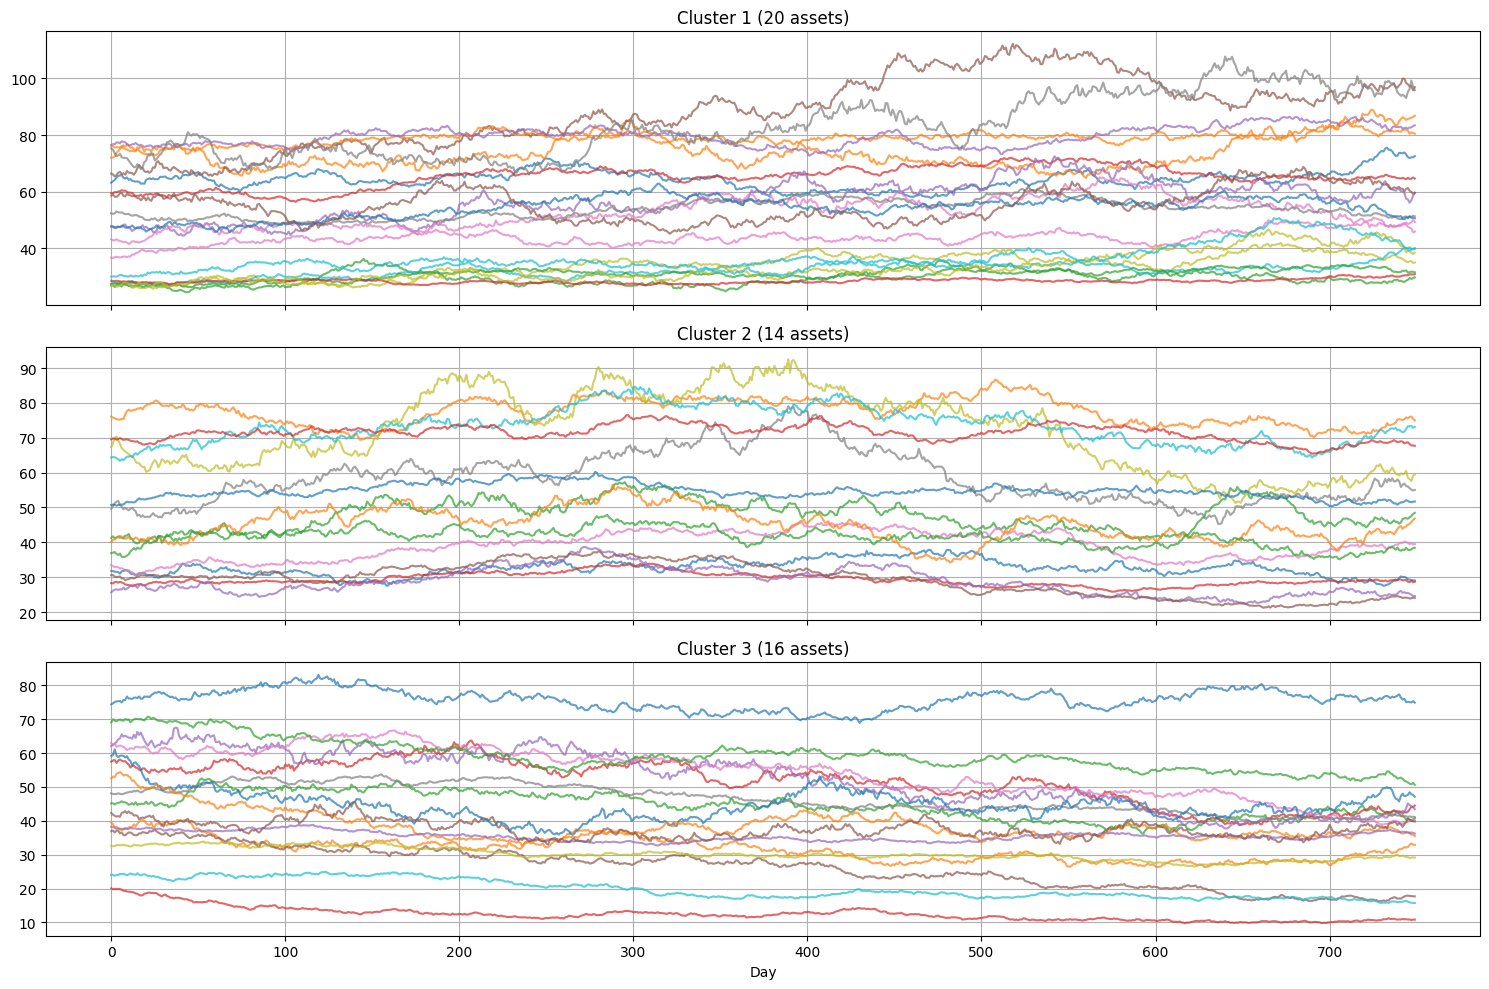

In [2]:
C1 = [36,46,10,39,11,23,7,13,12,17,34,48,49,45,24,28,26,22,29,42]
C2 = [3,44,41,5,27,30,21,14,9,31,15,32,18,38]
C3 = [40,43,35,16,2,6,4,20,19,47,37,25,1,33,0,8]
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
for i, C in enumerate([C1, C2, C3]):
    ax = axes[i]
    for c in C:
        ax.plot(prices.index, prices.iloc[:, c], alpha=0.7)
    ax.set_title(f"Cluster {i+1} ({len(C)} assets)")
    ax.grid(True)
plt.xlabel("Day")
plt.tight_layout()
plt.show()

# Mean Reversion Strategies:

- Mean reversion/Fair value/Bollinger/z-score for each stock -> see if the low vol clusters yield a higher score here

- Mean reversion for multiple assets/Pair trading/cluster mean trading/etc


(statistical arbitrage can also include other factors between assets, such as lead/lag, short term momentum, etc)

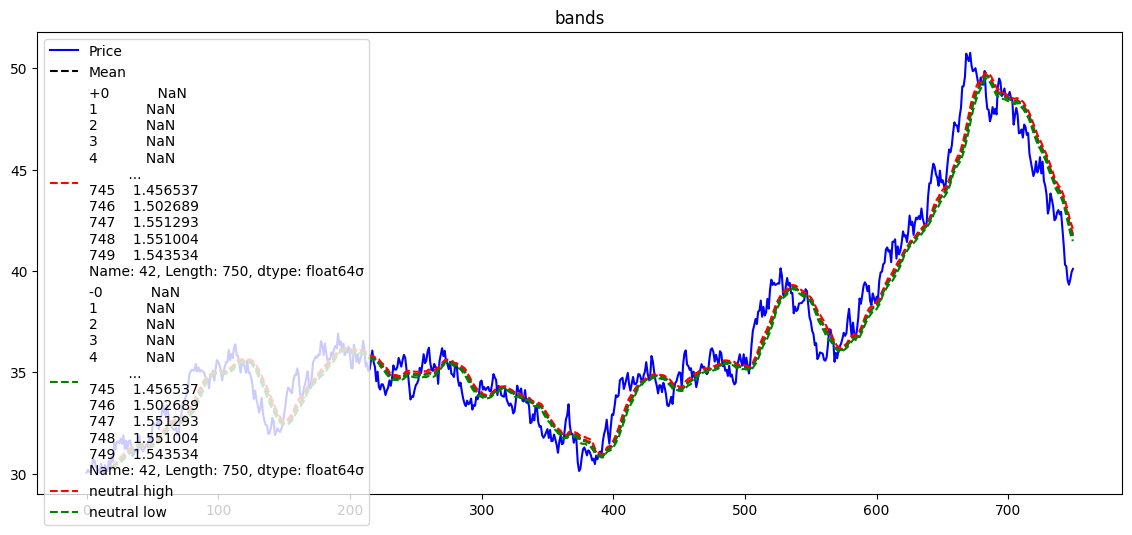

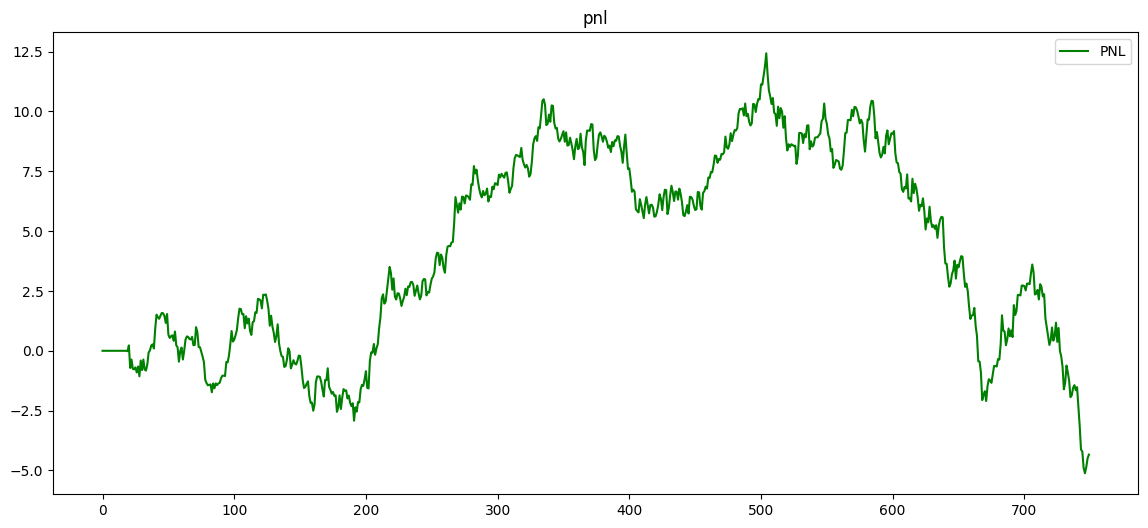

array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00, -1.5415000e-02,
        2.2458500e-01, -7.1541500e-01, -3.6541500e-01, -7.5541500e-01,
       -7.7541500e-01, -6.9541500e-01, -9.0541500e-01, -6.5541500e-01,
       -1.0654150e+00, -4.0541500e-01, -8.0541500e-01, -3.6541500e-01,
       -7.8541500e-01, -8.2541500e-01, -5.6541500e-01, -7.0850000e-02,
        1.9150000e-02,  2.1915000e-01,  2.6915000e-01,  9.9150000e-02,
        9.2321000e-01,  1.5075700e+00,  1.4075700e+00,  1.3375700e+00,
        1.4675700e+00,  1.5818850e+00,  1.5661600e+00,  1.4561600e+00,
        1.1661600e+00,  1.5361600e+00,  6.7616000e-01,  5.3616000e-01,
        6.0616000e-01,  6.4616000e-01,  4.1616000e-01,  8.0616000e-01,
      

In [3]:
#1 Individual Asset Mean Reversion
# PARAMTERS:
#- SMA/EWM/Params
#- Z-score/Bollinger/Size
# Normalised?
def mean_reversion(asset, plot=False, size=0.2, SMA=True,a=0.2,w=20, norm=True):
    if norm:
        asset = asset/asset.iloc[0]
    # 1: calculate moving average (EMA?) - df.ewm
    if SMA:
        MA = asset.rolling(window=w).mean() #SMA
    else:
        MA = asset.ewm(alpha=a).mean() #EMA
    # 2: calculate bands (z-score or bollinger, or a combo) - 
    #std = EMA.std()
    std = asset.rolling(window=w).std()
    bollinger_high = MA + std*size
    bollinger_low = MA - std*size
    # 3: if above, sell - if below, buy
    # Calculating Positions
    pos = np.zeros(len(asset))
    neut_high = MA+std*size/5
    neut_low = MA-std*size/5 
    Daily_PNL = np.zeros(len(asset))
    for i in range(len(asset)):
        if asset.iloc[i] > bollinger_high.iloc[i]:
            #Sell
            pos[i] = -1
        elif asset.iloc[i] < bollinger_low.iloc[i]:
            #Buy
            pos[i] = 1
        '''elif (asset.iloc[i] < neut_high.iloc[i]) and (asset.iloc[i] > neut_low.iloc[i]):
            pos[i] = 0'''

        if i>0:
            '''if pos[i] != pos[i-1]:
                Daily_PNL[i] = ((pos[i-1]-pos[i])*(asset[i]-asset[i-1]))*10000-(asset[i]*0.0005)*10000'''
            Daily_PNL[i] = pos[i-1] * (asset[i] - asset[i-1])
            if pos[i] != pos[i-1]:
                Daily_PNL[i] -= asset[i] * 0.0005
    if plot:
        plt.figure(figsize=(14, 6))
        plt.plot(asset, label='Price', color='blue')
        plt.plot(MA, '--', label='Mean', color='black')
        plt.plot(bollinger_high, '--', label=f'+{std}σ', color='red')
        plt.plot(bollinger_low, '--', label=f'-{std}σ', color='green')
        plt.plot(MA+std*size/5, '--', label=f'neutral high', color='red')
        plt.plot(MA-std*size/5, '--', label=f'neutral low', color='green')
        plt.title('bands')
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(14, 6))
        plt.plot(Daily_PNL.cumsum(), label='PNL', color='green')
        plt.title('pnl')
        plt.legend()
        plt.show()

    return(Daily_PNL.cumsum())
    
mean_reversion(prices[42], plot=True, norm=False)

In [4]:
# 3.5: test whether signal is overall profitable
# 4: optimise parameters, with underfit > overfit, for each stock
# 5: test
#def mean_reversion(asset, plot=False, size=0.2, SMA=True,a=0.2, norm=True):
# We grid search size (0.001<x<2), SMA/EMA(0<a<1), norm.

# Also experiment with selling when reaches neutral mean, etc

#Daily PNL is amount made at each tade, to see the nuanced volatility we'd need to calculate the actual value at any day, and compute selloffs when value is greater or less than $10,000

In [ ]:
from itertools import product
depth = 6

def evaluate_score(pnl):
    """Scoring function: mean - 0.1 * std"""
    return pnl.mean() - 0.1 * pnl.std()
def grid_search_mean_reversion(asset):
    """Run grid search over strategy parameters."""
    param_grid = {
        'size': np.linspace(0.01,1.5,8),
        'SMA': [True, False],
        'a': np.linspace(0.001,0.7,7),  # only used if SMA=False
        'norm': [True, False],
        'window': np.linspace(5,100,5).astype(int)  # only used if SMA=True
    }

    results = []
    for size, SMA, a, norm, window in product(*param_grid.values()):
        #(asset, plot=False, size=0.2, SMA=True,a=0.2,w=20, norm=True)
        pnl = mean_reversion(asset, size=size, SMA=SMA, a=a, w=window, norm=norm)

        score = evaluate_score(pnl)
        results.append({
            'score': score,
            'size': size,
            'SMA': SMA,
            'a': a,
            'norm': norm,
            'window': window,
            'pnl': pnl
        })

    results = sorted(results, key=lambda x: x['score'], reverse=True)
    best = results[0]
    return best

#print(grid_search_mean_reversion(prices[42]))

import time
start_time = time.time()
tuned_meanrev = []
for i in range(50):
    bestparams = grid_search_mean_reversion(prices[i])
    tuned_meanrev.append(bestparams)
    print('time:', time.time()-start_time, 'Score for Asset', i, '=',bestparams['score'])

time: 25.049386262893677 Score for Asset 0 = 2.9960037813256246
time: 48.001909017562866 Score for Asset 1 = 0.23653059598930148
time: 70.56072044372559 Score for Asset 2 = 20.986871557155457
time: 94.12126302719116 Score for Asset 3 = 8.543834691971126


In [ ]:
#print(tuned_meanrev)
#print(tuned_meanrev[2])
# Most seem to be: EMA with mid/high alpha, Un-normalised, small size
mean_reversion(prices[25],plot=True, size=0.000001, SMA=False,a=0.8,norm=True)

In [ ]:
# Plot all on default
plt.figure(figsize=(15, 5))
for col in prices.columns:
    plt.plot(prices.index, mean_reversion(prices[col]), alpha=0.4)

plt.title('Individual Mean Reversion (Untuned)')
plt.xlabel('Day')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Inhereintly we ought to store each assets optimal parameters in an array, given that it outperforms default sufficiently.

# Plot all on tuned
plt.figure(figsize=(15, 5))
for i in range(50):
    a =       tuned_meanrev[i]['a']
    size = tuned_meanrev[i]['size']
    w = tuned_meanrev[i]['window']
    SMA = tuned_meanrev[i]['SMA']
    #norm = tuned_meanrev[i]['norm']
    plt.plot(prices.index, mean_reversion(prices[i], size=size, a=a, w=w, SMA=SMA, norm=True), alpha=0.4)

plt.title('Individual Mean Reversion (Tuned)')
plt.xlabel('Day')
plt.ylabel('Price')
plt.grid(True)
plt.show()



plt.figure(figsize=(15, 5))
for col in prices.columns:
    plt.plot(prices.index, mean_reversion(prices[col], SMA=False, a=0.8, size=0.000001), alpha=0.4)

plt.title('Individual Mean Reversion (Semi-Tuned)')
plt.xlabel('Day')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [ ]:
#2 Multiple Asset Mean Reversion
#parameters; 
#-difference metric (ie contrarian mean reversion)
#-n-cluster - do we pair 2,3,4....etc, clusters?
def pair_reversion(asset1, asset2, plot=False, size=0.8): 
    # 1: calculate difference metrics; ie combined average normalised
    asset1 = asset1/asset1.iloc[0]
    asset2 = asset2/asset2.iloc[0]
    spread = asset1 - asset2
    EMA = spread.ewm(alpha=0.3).mean()
    # 2: position accordingly; short the one above and buy the one below

    # PARADIGM: When spread gap widens, we expect it to decrease
    # -> when spread above or below band
    pos_1 = np.zeros(len(asset1))
    pos_2 = np.zeros(len(asset1))
    Daily_PNL = np.zeros(len(asset1))
    for i in range(len(asset1)):
        if spread.iloc[-1] > EMA.iloc[-1]+spread.rolling(window=20).std().iloc[-1]*size:
            pos_1 = -1
            pos_2 = 1
        elif spread.iloc[-1] < EMA.iloc[-1]-spread.rolling(window=20).std().iloc[-1]*size:
            pos_1 = 1
            pos_2 = -1
        elif (spread.iloc[i] < EMA.iloc[-1]-spread.rolling(window=20).std().iloc[-1]*size/5) and (spread.iloc[i] > EMA.iloc[-1]-spread.rolling(window=20).std().iloc[-1]*size/5):
            pos_1 = 0
            pos_2 = 0

        if i>0:
            Daily_PNL[i] += pos_1[i-1] * (asset1[i] - asset1[i-1]) * 10000
            Daily_PNL[i] += pos_2[i-1] * (asset2[i] - asset2[i-1]) * 10000
            if pos_1[i] != pos_1[i-1]: #if changed, add transaction fee
                Daily_PNL[i] -= asset1[i] * 0.0005 * 10000
                Daily_PNL[i] -= asset2[i] * 0.0005 * 10000
    # Lets consider contrarian mean reversion between correlated clusters
    if plot:
        plt.figure(figsize=(14, 6))
        plt.plot(spread)
        plt.plot(asset1-1, alpha=0.4, label='Asset1')
        plt.plot(asset2-1, alpha=0.4,  label='Asset2')
        plt.plot((asset1+asset2)/2-1, alpha=0.07)
        plt.plot(EMA+spread.rolling(window=20).std()*size, alpha=0.4, label='BANDUP')
        plt.plot(EMA-spread.rolling(window=20).std()*size, alpha=0.4,  label='BANDDOWN')
        plt.title('spread')
        plt.legend()
        plt.legend()
        plt.show()

        plt.figure(figsize=(14, 6))
        plt.plot(Daily_PNL)
        plt.title('pnl')
        plt.legend()
        plt.legend()
        plt.show()
pair_reversion(prices[1], prices[2], plot=True)

In [ ]:
# Clusters - no obvious relationship found here other than somehow the high variance clusters somehow has less variance here
C1_Low = [13,45,24,39,48,36,49,46,23,17,34,26]
C1_High = [10,22,29,11,28,7,12,42]
C2_Low = [31,30,21,38,44,5,15]
C2_High = [3,18,14,27,32,41,9]
C3_High = [35,47,16,25,37,8,6,33,43,2]
C3_Low = [0,20,19,4,40,1]
for C in [C1_Low,C2_Low,C3_Low,C1_High,C2_High,C3_High]:
    plt.figure(figsize=(15, 8))
    for c in C:
        tuned_meanrev[c]
        plt.plot(prices.index, mean_reversion(prices[c], SMA=tuned_meanrev[c]['SMA'],w=tuned_meanrev[c]['window'], a=tuned_meanrev[c]['a'], size=tuned_meanrev[c]['size']), alpha=0.4)
    
    plt.title(f'Semi-Tuned Cluster-Base Reversion per cluster')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.grid(True)
    plt.show()

In [ ]:
def grid_search_mean_reversion(asset):
    """Run grid search over strategy parameters."""
    param_grid = {
        'size': np.linspace(0.01,1.2,10),
        'a': np.linspace(0.01,1,10),  # only used if SMA=False
    }

    results = []
    for size, a in product(*param_grid.values()):
        #(asset, plot=False, size=0.2, SMA=True,a=0.2,w=20, norm=True)
        pnl = mean_reversion(asset, size=size, SMA=False, a=a, norm=True)

        score = evaluate_score(pnl)
        results.append({
            'score': score,
            'size': size,
            'a': a
        })

    results = sorted(results, key=lambda x: x['score'], reverse=True)
    best = results[0]
    return best

start_time = time.time()
print(start_time)
'''tuned_meanrev = []
for i in range(50):
    bestparams = grid_search_mean_reversion(prices[i])
    tuned_meanrev.append(bestparams)
    print('time:', time.time()-start_time, 'Score for Asset', i, '=',bestparams['score'], bestparams['size'], bestparams['a'])'''

tuned_pairs = []
bestcomb = np.zeros(50)
bestscore = np.zeros(50)
for i in range(50):
    for j in range(50):
        if j > i:
            bestparams = grid_search_mean_reversion(prices[i]-prices[j])
            tuned_pairs.append(bestparams)
            if bestparams['score'] > bestscore[i]:
                bestcomb[i] = j
                bestscore[i] = bestparams['score']
                print('time:', time.time()-start_time,i,j, 'Score', bestparams['score'], bestparams['size'], bestparams['a'])

In [ ]:
T = tuned_meanrev
for t in T:
    print(t['score'], t['SMA'], t['window'], t['a'], t['size'], t['norm'])
#print(T)

In [ ]:
# Also need to experiment of when to go neutral - currently 1/5 of band size
# Also decay rate of EMA needn't be a constant

In [ ]:
profit = mean_reversion(prices[1]-prices[2], plot=True, size=0.5, SMA=True,a=0.2,w=20, norm=True)
P1 = mean_reversion(prices[1], plot=False, size=0.5, SMA=True,a=0.2,w=20, norm=True)
P2 = mean_reversion(prices[2], plot=False, size=0.5, SMA=True,a=0.2,w=20, norm=True)
print(profit - P1 - P2)

In [ ]:
plt.figure(figsize=(15, 8))
for i in range(50):
    for j in range(50):
        if j > i:
            plt.plot(mean_reversion(prices[i]-prices[j], plot=False, size=0.01, SMA=False,a=0.3,w=20, norm=True), alpha=0.35)
plt.title(f'All combinations of pair trading for some arbitrary params')
plt.xlabel('Day')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# By Cluster:
import itertools
C1_Low = [13,45,24,39,48,36,49,46,23,17,34,26]
C1_High = [10,22,29,11,28,7,12,42]
C2_Low = [31,30,21,38,44,5,15]
C2_High = [3,18,14,27,32,41,9]
C3_High = [35,47,16,25,37,8,6,33,43,2]
C3_Low = [0,20,19,4,40,1]
for C in [C1_Low,C2_Low,C3_Low,C1_High,C2_High,C3_High]:
    plt.figure(figsize=(15, 8))
    combinations = itertools.combinations(C, r=2)
    for pair in combinations:
        plt.plot(mean_reversion(prices[pair[0]]-prices[pair[1]], plot=False, size=0.01, SMA=False,a=0.3,w=20, norm=True), alpha=0.35)
    plt.title(f'pair trading within clusters')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.grid(True)
    plt.show()